## Importing Data

Import the unclean, raw, scraped data from Realtor.com

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("unclean.csv")

/tmp/ipykernel_2146/2658663043.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("unclean.csv")


In [2]:
df["Property Value"].min()


'$1'

## Display Head

In [3]:
df.head()

Property Link       Type of House  \
0  https://www.realtor.com/realestateandhomes-det...      Condo for sale   
1  https://www.realtor.com/realestateandhomes-det...      Condo for sale   
2  https://www.realtor.com/realestateandhomes-det...  Townhouse for sale   
3  https://www.realtor.com/realestateandhomes-det...      House for sale   
4  https://www.realtor.com/realestateandhomes-det...      House for sale   

  Property Value bed  bath  \nbed Area (Sqft)  \
0   $150,000,000   8    10    8.0      11,535   
1       $649,000   3   2.5    3.0       2,431   
2     $6,999,999   6  6.5+    6.0       7,200   
3    $18,000,000   8  16.5    8.0      33,000   
4       $274,000   3     1    3.0       1,556   

                       Address line 1              Address line 2  \
0          217 W 57th St Unit 127/128         Manhattan, NY 10019   
1  764 Saint Nicholas /C2 Ave Unit C1          New York, NY 10031   
2                        34 W 89th St         Manhattan, NY 10024   
3                     177 Benedict Rd     Staten Island, NY 10304   
4                     115-30 116th St  South Ozone Park, NY 11420   

                                      Full Address_x  ...  \
0     217 W 57th St Unit 127/128 Manhattan, NY 10019  ...   
1  764 Saint Nicholas /C2 Ave Unit C1 New York, N...  ...   
2                   34 W 89th St Manhattan, NY 10024  ...   
3            177 Benedict Rd Staten Island, NY 10304  ...   
4         115-30 116th St South Ozone Park, NY 11420  ...   

  Distance_to_Nearest_Trains_miles Number_of_Airports_Nearby  \
0                         0.130121                         1   
1                         0.157511                         0   
2                         0.153621                         0   
3                         0.804044                         0   
4                         0.726807                         0   

  Distance_to_Nearest_Airports_miles Number_of_Museums_Nearby  \
0                           2.205337                       34   
1                                inf                       14   
2                                inf                       17   
3                                inf                        4   
4                                inf                        0   

   Distance_to_Nearest_Museums_miles  Number_of_Libraries_Nearby  \
0                           0.466477                          26   
1                           0.313484                           9   
2                           0.458300                          22   
3                           2.116247                           1   
4                                inf                           1   

   Distance_to_Nearest_Libraries_miles  Number_of_Grocery_stores_Nearby  \
0                             0.228443                              194   
1                             0.372547                              101   
2                             0.580740                              154   
3                             1.616244                               22   
4                             1.638993                               52   

   Distance_to_Nearest_Grocery_stores_miles        borough  
0                                  0.151832      Manhattan  
1                                  0.235285      Manhattan  
2                                  0.129664      Manhattan  
3                                  1.005562  Staten Island  
4                                  0.216965         Queens  

[5 rows x 45 columns]

Dropping exactly duplicate rows

In [4]:
# Drop rows that are exactly the same across all columns
df.drop_duplicates(keep="first", inplace=True)


In [5]:
df.shape

(10471, 45)

Dropping rows with missing target variable

In [6]:
df = df.dropna(subset=['Property Value']).copy()

## Removing unwanted columns

Removing irrelevant columns to our model such as the property URL, Address data, etc.

In [7]:
# Remove unwanted columns
columns_to_drop = [
    "Property Link",
    "Address line 1",
    "Address line 2",
    "Full Address_x",
    "Full Address_y",
    "\nbed",
    "appreciate/depreciate",
    
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

## Converting datatypes

Remove "$" from target and convert to numerical.

In [8]:
# Step 2: Clean the 'Property Value' column
# Remove $ and , and handle non-numeric values like "Contact for price"
df["Property Value"] = (
    df["Property Value"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

# Remove rows where 'Property Value' is non-numeric (e.g., "Contact for price")
df = df[df["Property Value"].str.replace(".", "", regex=False).str.isnumeric()]

df["Property Value"] = df["Property Value"].astype(float)

print(df["Property Value"].head())


0    150000000.0
1       649000.0
2      6999999.0
3     18000000.0
4       274000.0
Name: Property Value, dtype: float64


## Normalize units (lot size)


Creating a derived variable called "Total lot size" from "lot type" and "lot size"

In [9]:
# 1. Rename the lot type column
df.rename(
    columns={"PropertyLotSizeMetastyles__StyledPropertyLotSizeMeta-rui__sc-1cz4zco-0": "lot type"},
    inplace=True
)

# 2. Clean and convert lot size & area to numeric
df["lot size"] = pd.to_numeric(df["lot size"].astype(str).str.replace(",", ""), errors="coerce")
df["Area (Sqft)"] = pd.to_numeric(df["Area (Sqft)"].astype(str).str.replace(",", ""), errors="coerce")

# 3. Compute total lot size based on logic
def compute_total_lot_size(row):
    lot_type = str(row["lot type"]).lower() if pd.notna(row["lot type"]) else ""
    lot_size = row["lot size"]
    area_sqft = row["Area (Sqft)"]

    if "acre lot" in lot_type and pd.notna(lot_size):
        return lot_size * 43560
    elif "sqft lot" in lot_type and pd.notna(lot_size):
        return lot_size
    else:
        return area_sqft  # Always fallback to Area (Sqft)

df["total lot size(sqft)"] = df.apply(compute_total_lot_size, axis=1)

df["total lot size(sqft)"] = pd.to_numeric(df["total lot size(sqft)"], errors="coerce")


In [10]:
df.drop(columns=["lot size", "lot type"], inplace=True)

In [11]:
df.head()

Type of House  Property Value bed  bath  Area (Sqft)   Latitude  \
0      Condo for sale     150000000.0   8    10      11535.0  40.766474   
1      Condo for sale        649000.0   3   2.5       2431.0  40.826130   
2  Townhouse for sale       6999999.0   6  6.5+       7200.0  40.787587   
3      House for sale      18000000.0   8  16.5      33000.0  40.595008   
4      House for sale        274000.0   3     1       1556.0  40.675746   

   Longitude  Number_of_Parks_Nearby  Distance_to_Nearest_Parks_miles  \
0 -73.981266                      16                         0.516540   
1 -73.943006                      37                         0.057431   
2 -73.969240                      19                         0.148955   
3 -74.106434                       1                         1.515412   
4 -73.822413                      14                         0.953825   

   Number_of_Malls_Nearby  ...  Number_of_Airports_Nearby  \
0                       3  ...                          1   
1                       0  ...                          0   
2                       2  ...                          0   
3                       0  ...                          0   
4                       1  ...                          0   

   Distance_to_Nearest_Airports_miles  Number_of_Museums_Nearby  \
0                            2.205337                        34   
1                                 inf                        14   
2                                 inf                        17   
3                                 inf                         4   
4                                 inf                         0   

   Distance_to_Nearest_Museums_miles  Number_of_Libraries_Nearby  \
0                           0.466477                          26   
1                           0.313484                           9   
2                           0.458300                          22   
3                           2.116247                           1   
4                                inf                           1   

   Distance_to_Nearest_Libraries_miles  Number_of_Grocery_stores_Nearby  \
0                             0.228443                              194   
1                             0.372547                              101   
2                             0.580740                              154   
3                             1.616244                               22   
4                             1.638993                               52   

   Distance_to_Nearest_Grocery_stores_miles        borough  \
0                                  0.151832      Manhattan   
1                                  0.235285      Manhattan   
2                                  0.129664      Manhattan   
3                                  1.005562  Staten Island   
4                                  0.216965         Queens   

   total lot size(sqft)  
0               11535.0  
1                2431.0  
2                7200.0  
3               68824.8  
4                2400.0  

[5 rows x 37 columns]

## Handling missing values (Through Imputation)

Displaying missing values

In [12]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())



--- Missing Values per Column ---
Type of House                                  0
Property Value                                 0
bed                                          207
bath                                         316
Area (Sqft)                                 2800
Latitude                                       0
Longitude                                      0
Number_of_Parks_Nearby                         0
Distance_to_Nearest_Parks_miles                0
Number_of_Malls_Nearby                         0
Distance_to_Nearest_Malls_miles                0
Number_of_Metros_Nearby                        0
Distance_to_Nearest_Metros_miles               0
Number_of_Clubs_Nearby                         0
Distance_to_Nearest_Clubs_miles                0
Number_of_Restaurants_Nearby                   0
Distance_to_Nearest_Restaurants_miles          0
Number_of_Schools_Nearby                       0
Distance_to_Nearest_Schools_miles              0
Number_of_Colleges_Nearby         

For "Bed" and "Bath" we impute with mode

In [13]:
# Impute 'bed'
most_common_bed = df["bed"].mode()[0]
df["bed"].fillna(most_common_bed, inplace=True)

# Impute 'bath'
median_bath = df["bath"].mode()[0]
df["bath"].fillna(median_bath, inplace=True)

/tmp/ipykernel_2146/337580240.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bed"].fillna(most_common_bed, inplace=True)
/tmp/ipykernel_2146/337580240.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

For Area sq.ft we fill missing Area using group-wise median

In [14]:
df["Area (Sqft)"] = (
    df["Area (Sqft)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace("nan", np.nan) 
    .astype(float)
)


In [15]:
df["Area (Sqft)_original"] = df["Area (Sqft)"]

df["bed"] = df["bed"].fillna(df["bed"].mode()[0])
df["bed"] = df["bed"].astype(str)  # just to be sure for grouping

def impute_area(row):
    if pd.isna(row["Area (Sqft)"]):
        # Try grouping by bed + type + borough
        group_median = grouped_medians.get((row["bed"], row["Type of House"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        # fallback to just bed + borough
        group_median = fallback_medians.get((row["bed"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        # fallback to bed only
        group_median = bed_medians.get(row["bed"])
        if pd.notna(group_median):
            return group_median
        # fallback to global median
        return df["Area (Sqft)"].median()
    return row["Area (Sqft)"]

# Create median mappings
grouped_medians = df.groupby(["bed", "Type of House", "borough"])["Area (Sqft)"].median().to_dict()
fallback_medians = df.groupby(["bed", "borough"])["Area (Sqft)"].median().to_dict()
bed_medians = df.groupby("bed")["Area (Sqft)"].median().to_dict()

df["Area (Sqft)"] = df.apply(impute_area, axis=1)


We Impute in same way for Total Lot size(sqft)

In [16]:
df["total lot size(sqft)_original"] = df["total lot size(sqft)"]

df["bed"] = df["bed"].fillna(df["bed"].mode()[0])
df["bed"] = df["bed"].astype(str)

# 3. Define imputation function
def impute_total_lot_size(row):
    if pd.isna(row["total lot size(sqft)"]):
        # First: bed + type + borough
        group_median = grouped_medians.get((row["bed"], row["Type of House"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        # Fallback: bed + borough
        group_median = fallback_medians.get((row["bed"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        # Fallback: bed only
        group_median = bed_medians.get(row["bed"])
        if pd.notna(group_median):
            return group_median
        # Final fallback: global median
        return df["total lot size(sqft)"].median()
    return row["total lot size(sqft)"]

# 4. Create group-wise medians
grouped_medians = df.groupby(["bed", "Type of House", "borough"])["total lot size(sqft)"].median().to_dict()
fallback_medians = df.groupby(["bed", "borough"])["total lot size(sqft)"].median().to_dict()
bed_medians = df.groupby("bed")["total lot size(sqft)"].median().to_dict()

df["total lot size(sqft)"] = df.apply(impute_total_lot_size, axis=1)


In [17]:
df.drop(columns=["Area (Sqft)_original", "total lot size(sqft)_original"], inplace=True)


There are no more missing values as you can see

In [18]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())
# See data types of each column
df.dtypes



--- Missing Values per Column ---
Type of House                               0
Property Value                              0
bed                                         0
bath                                        0
Area (Sqft)                                 0
Latitude                                    0
Longitude                                   0
Number_of_Parks_Nearby                      0
Distance_to_Nearest_Parks_miles             0
Number_of_Malls_Nearby                      0
Distance_to_Nearest_Malls_miles             0
Number_of_Metros_Nearby                     0
Distance_to_Nearest_Metros_miles            0
Number_of_Clubs_Nearby                      0
Distance_to_Nearest_Clubs_miles             0
Number_of_Restaurants_Nearby                0
Distance_to_Nearest_Restaurants_miles       0
Number_of_Schools_Nearby                    0
Distance_to_Nearest_Schools_miles           0
Number_of_Colleges_Nearby                   0
Distance_to_Nearest_Colleges_miles          0

Type of House                                object
Property Value                              float64
bed                                          object
bath                                         object
Area (Sqft)                                 float64
Latitude                                    float64
Longitude                                   float64
Number_of_Parks_Nearby                        int64
Distance_to_Nearest_Parks_miles             float64
Number_of_Malls_Nearby                        int64
Distance_to_Nearest_Malls_miles             float64
Number_of_Metros_Nearby                       int64
Distance_to_Nearest_Metros_miles            float64
Number_of_Clubs_Nearby                        int64
Distance_to_Nearest_Clubs_miles             float64
Number_of_Restaurants_Nearby                  int64
Distance_to_Nearest_Restaurants_miles       float64
Number_of_Schools_Nearby                      int64
Distance_to_Nearest_Schools_miles           float64
Number_of_Co

In [19]:
df.shape

(10470, 37)

## Handling Outliers

In [20]:
numeric_cols = [
    "Property Value",
    "Area (Sqft)",
    "total lot size(sqft)",
    "Number_of_Parks_Nearby",
    "Number_of_Malls_Nearby",
    "Number_of_Metros_Nearby",
    "Number_of_Clubs_Nearby",
    "Number_of_Restaurants_Nearby",
    "Number_of_Schools_Nearby",
    "Number_of_Colleges_Nearby",
    "Number_of_Universities_Nearby",
    "Number_of_Buses_Nearby",
    "Number_of_Trains_Nearby",
    "Number_of_Airports_Nearby",
    "Number_of_Museums_Nearby",
    "Number_of_Libraries_Nearby",
    "Number_of_Grocery_stores_Nearby"
]


In [21]:
min_caps = {
    "Property Value": 50000,
    "Area (Sqft)": 200,
    "total lot size(sqft)": 200,
    "Number_of_Parks_Nearby": 0,
    "Number_of_Malls_Nearby": 0,
    "Number_of_Metros_Nearby": 0,
    "Number_of_Clubs_Nearby": 0,
    "Number_of_Restaurants_Nearby": 0,
    "Number_of_Schools_Nearby": 0,
    "Number_of_Colleges_Nearby": 0,
    "Number_of_Universities_Nearby": 0,
    "Number_of_Buses_Nearby": 0,
    "Number_of_Trains_Nearby": 0,
    "Number_of_Airports_Nearby": 0,
    "Number_of_Museums_Nearby": 0,
    "Number_of_Libraries_Nearby": 0,
    "Number_of_Grocery_stores_Nearby": 0
}


In [22]:
def clip_outliers_iqr(df, columns, iqr_factor=1.5, min_caps=None):
    df_clipped = df.copy()
    for col in columns:
        if col in df_clipped.columns:
            Q1 = df_clipped[col].quantile(0.25)
            Q3 = df_clipped[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - iqr_factor * IQR
            upper = Q3 + iqr_factor * IQR

            # Apply user-defined minimum cap if provided
            if min_caps and col in min_caps:
                lower = max(lower, min_caps[col])

            before_min = df_clipped[col].min()
            before_max = df_clipped[col].max()

            df_clipped[col] = df_clipped[col].clip(lower=lower, upper=upper)

            print(f"✅ {col}: clipped to [{lower:,.0f}, {upper:,.0f}] | Before: ({before_min:,.0f}, {before_max:,.0f}) → After: ({df_clipped[col].min():,.0f}, {df_clipped[col].max():,.0f})")
    return df_clipped


In [23]:
df = clip_outliers_iqr(df, numeric_cols, iqr_factor=1.5, min_caps=min_caps)


✅ Property Value: clipped to [50,000, 3,557,950] | Before: (1, 150,000,000) → After: (50,000, 3,557,950)
✅ Area (Sqft): clipped to [200, 4,522] | Before: (167, 212,250) → After: (200, 4,522)
✅ total lot size(sqft): clipped to [200, 9,792] | Before: (167, 95,091,480) → After: (200, 9,792)
✅ Number_of_Parks_Nearby: clipped to [0, 42] | Before: (0, 57) → After: (0, 42)
✅ Number_of_Malls_Nearby: clipped to [0, 5] | Before: (0, 3) → After: (0, 3)
✅ Number_of_Metros_Nearby: clipped to [0, 225] | Before: (0, 165) → After: (0, 165)
✅ Number_of_Clubs_Nearby: clipped to [0, 66] | Before: (0, 57) → After: (0, 57)
✅ Number_of_Restaurants_Nearby: clipped to [0, 5,563] | Before: (0, 3,475) → After: (0, 3,475)
✅ Number_of_Schools_Nearby: clipped to [0, 386] | Before: (0, 233) → After: (0, 233)
✅ Number_of_Colleges_Nearby: clipped to [0, 24] | Before: (0, 16) → After: (0, 16)
✅ Number_of_Universities_Nearby: clipped to [0, 32] | Before: (0, 23) → After: (0, 23)
✅ Number_of_Buses_Nearby: clipped to [0,

In [24]:
df.shape


(10470, 37)

In [25]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())


--- Missing Values per Column ---
Type of House                               0
Property Value                              0
bed                                         0
bath                                        0
Area (Sqft)                                 0
Latitude                                    0
Longitude                                   0
Number_of_Parks_Nearby                      0
Distance_to_Nearest_Parks_miles             0
Number_of_Malls_Nearby                      0
Distance_to_Nearest_Malls_miles             0
Number_of_Metros_Nearby                     0
Distance_to_Nearest_Metros_miles            0
Number_of_Clubs_Nearby                      0
Distance_to_Nearest_Clubs_miles             0
Number_of_Restaurants_Nearby                0
Distance_to_Nearest_Restaurants_miles       0
Number_of_Schools_Nearby                    0
Distance_to_Nearest_Schools_miles           0
Number_of_Colleges_Nearby                   0
Distance_to_Nearest_Colleges_miles          0

## Feature Engineering (Binning)

In [26]:
import numpy as np
import pandas as pd

distance_cols = [col for col in df.columns if "Distance_to" in col and "miles" in col]

bins = [0, 1, 2, 3, 4, 5, np.inf]
labels = ["0–1 miles", "1–2 miles", "2–3 miles", "3–4 miles", "4–5 miles", "5+ miles"]

for col in distance_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    binned_col = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    binned_col = binned_col.cat.add_categories("Unknown").fillna("Unknown")
    new_col_name = f"{col}_binned"
    df[new_col_name] = binned_col

    df.drop(columns=[col], inplace=True)


/tmp/ipykernel_2146/3436953979.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_2146/3436953979.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [27]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['Type of House', 'bed', 'bath', 'borough', 'Distance_to_Nearest_Parks_miles_binned', 'Distance_to_Nearest_Malls_miles_binned', 'Distance_to_Nearest_Metros_miles_binned', 'Distance_to_Nearest_Clubs_miles_binned', 'Distance_to_Nearest_Restaurants_miles_binned', 'Distance_to_Nearest_Schools_miles_binned', 'Distance_to_Nearest_Colleges_miles_binned', 'Distance_to_Nearest_Universities_miles_binned', 'Distance_to_Nearest_Buses_miles_binned', 'Distance_to_Nearest_Trains_miles_binned', 'Distance_to_Nearest_Airports_miles_binned', 'Distance_to_Nearest_Museums_miles_binned', 'Distance_to_Nearest_Libraries_miles_binned', 'Distance_to_Nearest_Grocery_stores_miles_binned']


## Encoding categorical values using One-Hot encoding

In [28]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [29]:
df_encoded = df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
df_encoded.head()

/tmp/ipykernel_2146/1561826786.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))


Property Value  Area (Sqft)   Latitude  Longitude  Number_of_Parks_Nearby  \
0       3557950.0      4521.75  40.766474 -73.981266                      16   
1        649000.0      2431.00  40.826130 -73.943006                      37   
2       3557950.0      4521.75  40.787587 -73.969240                      19   
3       3557950.0      4521.75  40.595008 -74.106434                       1   
4        274000.0      1556.00  40.675746 -73.822413                      14   

   Number_of_Malls_Nearby  Number_of_Metros_Nearby  Number_of_Clubs_Nearby  \
0                       3                      110                      30   
1                       0                       72                       5   
2                       2                       88                       7   
3                       0                        7                       1   
4                       1                       30                       7   

   Number_of_Restaurants_Nearby  Number_of_Schools_Nearby  ...  \
0                          2786                       165  ...   
1                           572                       220  ...   
2                          1933                       192  ...   
3                           173                        16  ...   
4                           252                        32  ...   

   Distance_to_Nearest_Libraries_miles_binned_3–4 miles  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   Distance_to_Nearest_Libraries_miles_binned_4–5 miles  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   Distance_to_Nearest_Libraries_miles_binned_5+ miles  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Distance_to_Nearest_Libraries_miles_binned_Unknown  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

   Distance_to_Nearest_Grocery_stores_miles_binned_1–2 miles  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  1           
4                                                  0           

   Distance_to_Nearest_Grocery_stores_miles_binned_2–3 miles  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   Distance_to_Nearest_Grocery_stores_miles_binned_3–4 miles  \
0                                                  0           
1                                                  0           
2                                                  0           
3                                                  0           
4                                                  0           

   Distance_to_Nearest_Grocery_stores_miles_binned_4–5 miles  \
0                                  

In [30]:
print(df_encoded[['Property Value', 'Area (Sqft)', 'total lot size(sqft)']].describe())

       Property Value   Area (Sqft)  total lot size(sqft)
count    1.047000e+04  10470.000000          10470.000000
mean     1.324122e+06   1771.037106           3207.447822
std      1.078599e+06   1150.350722           2698.544721
min      5.000000e+04    200.000000            200.000000
25%      5.447000e+05    885.500000           1115.500000
50%      8.990000e+05   1350.000000           2258.500000
75%      1.750000e+06   2340.000000           4586.000000
max      3.557950e+06   4521.750000           9791.750000


## Visualization

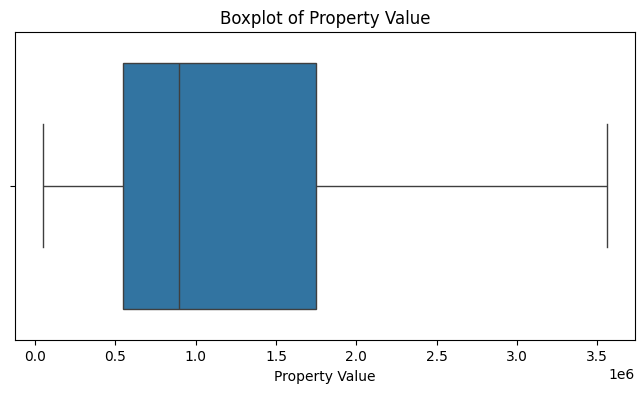

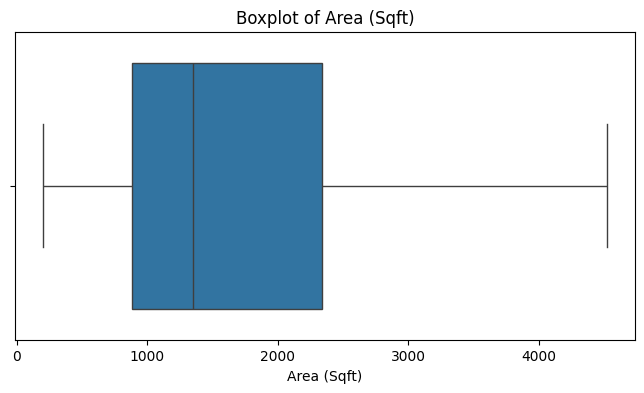

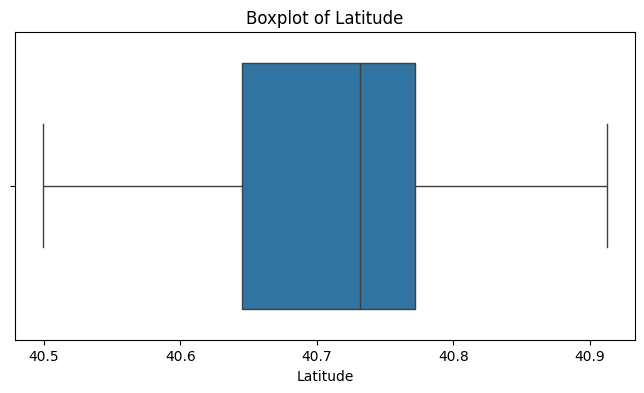

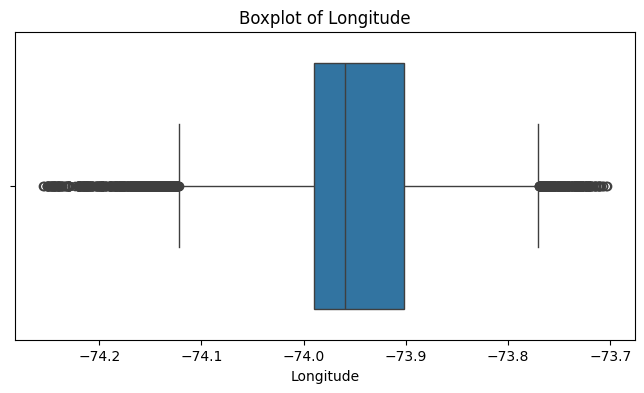

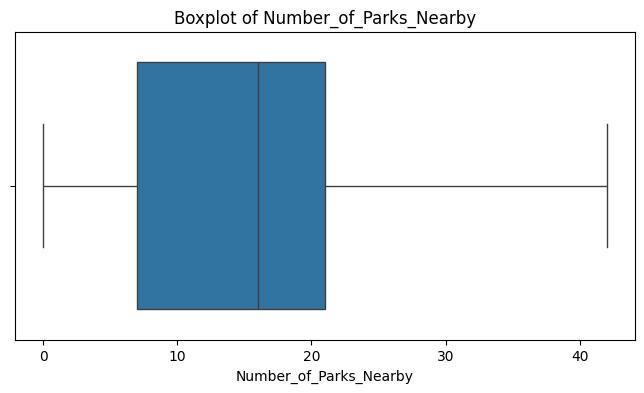

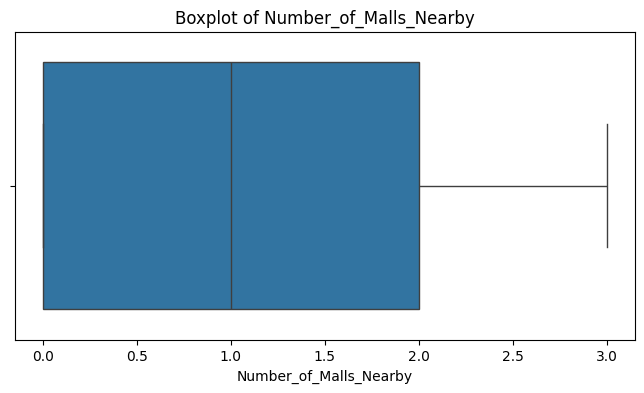

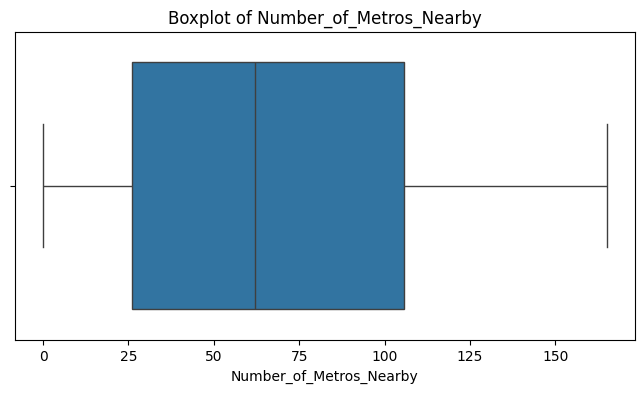

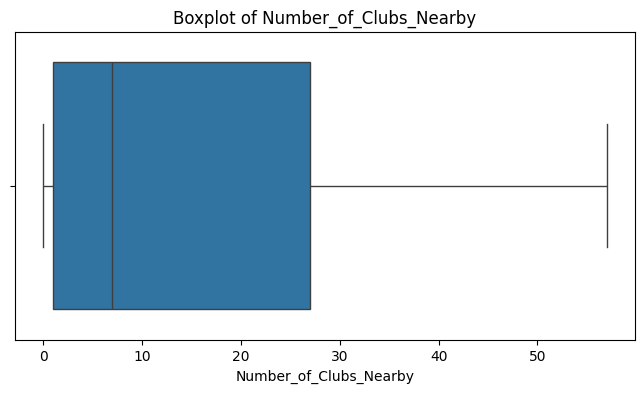

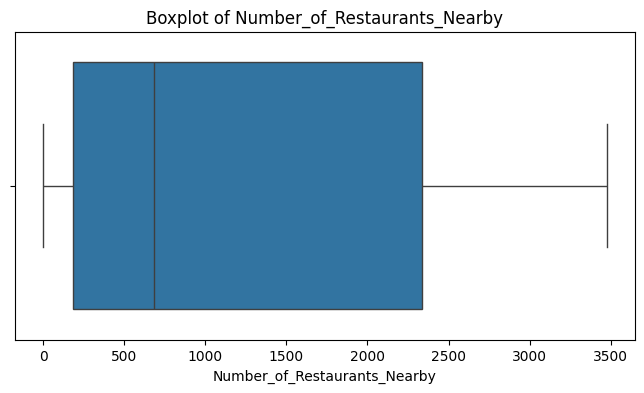

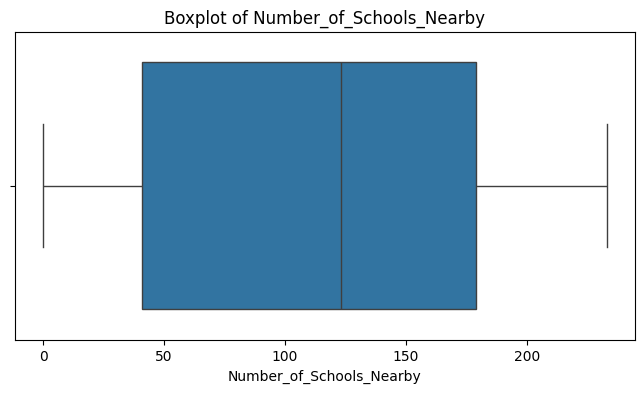

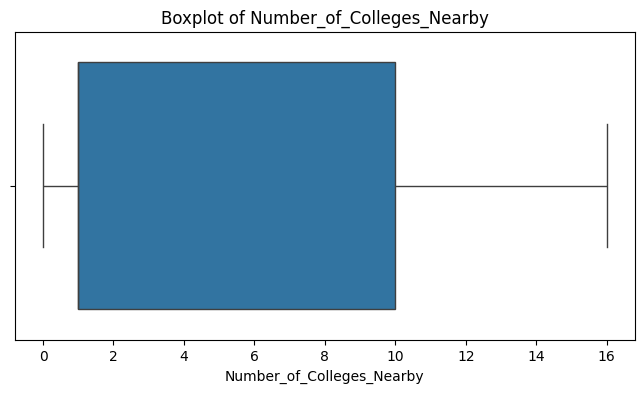

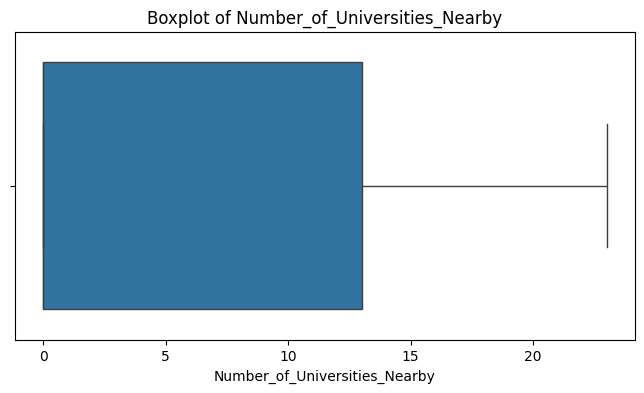

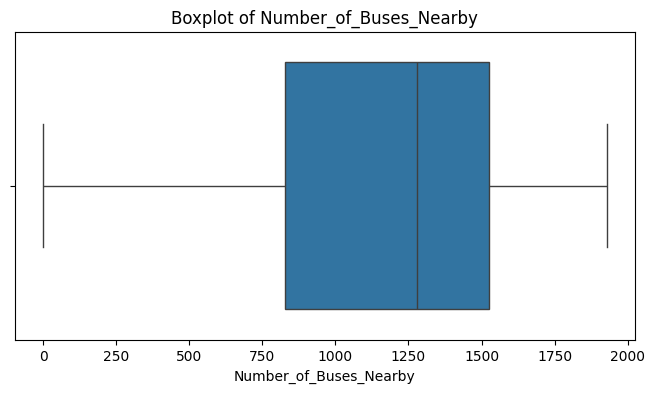

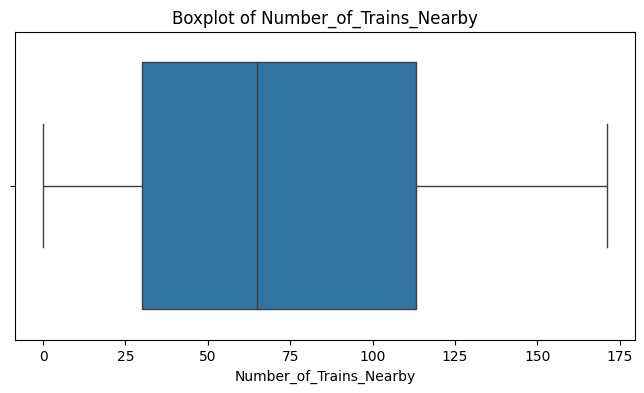

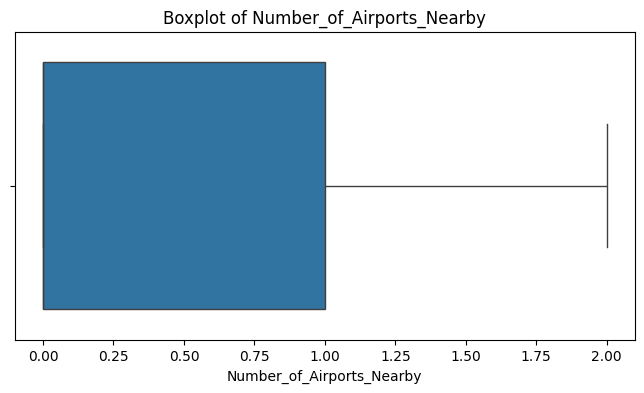

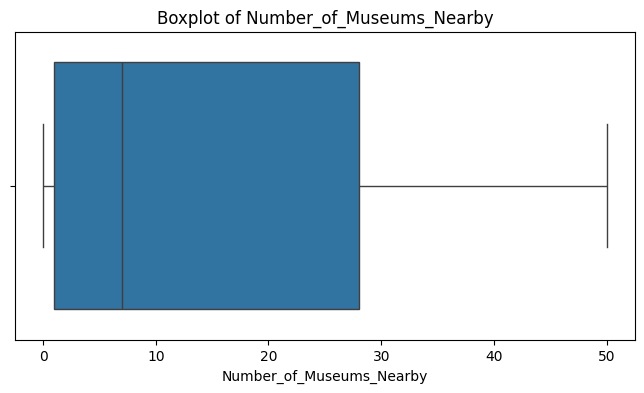

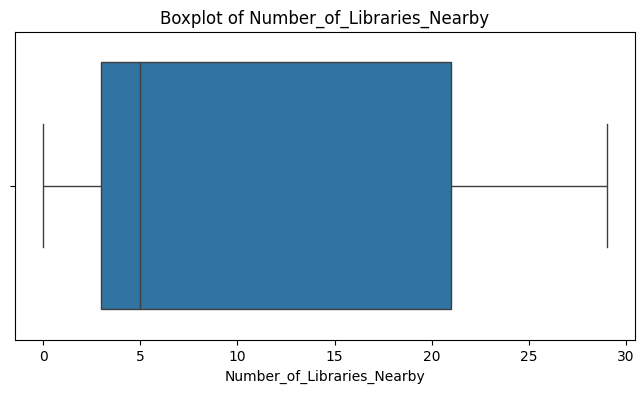

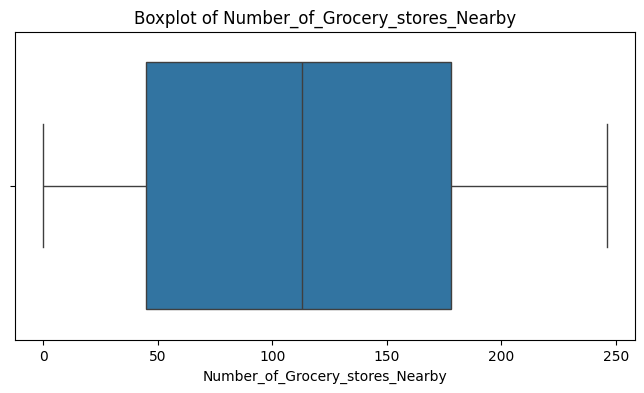

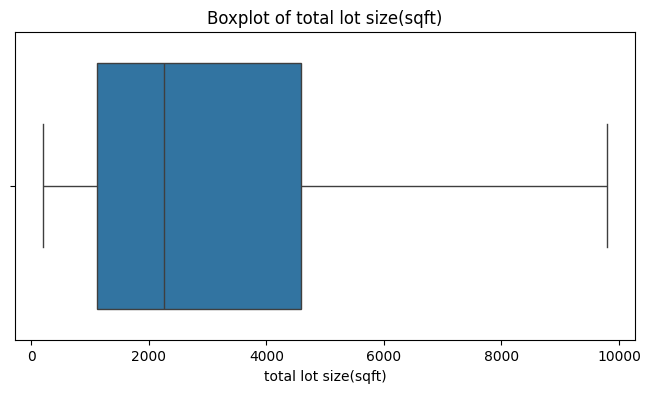

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

plt.show()

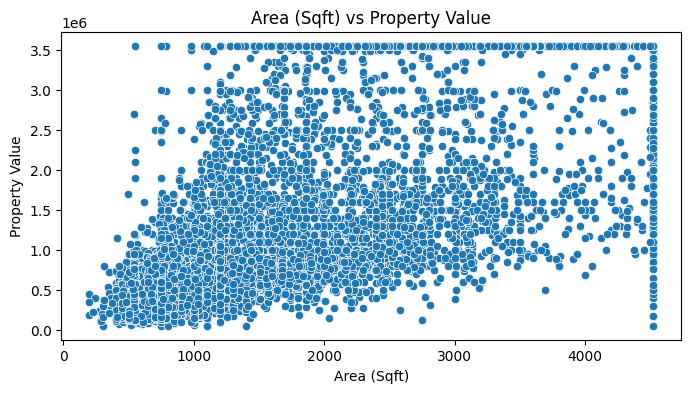

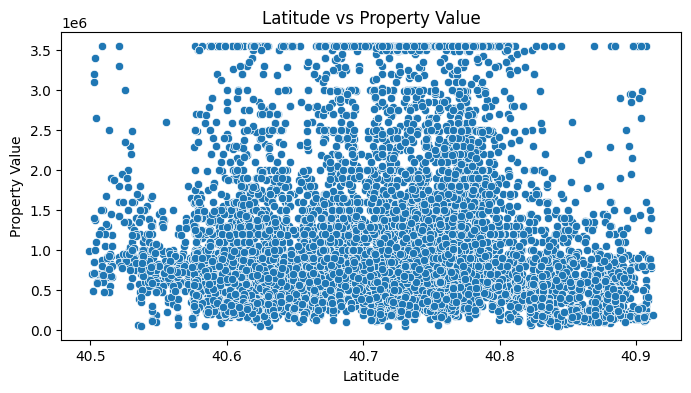

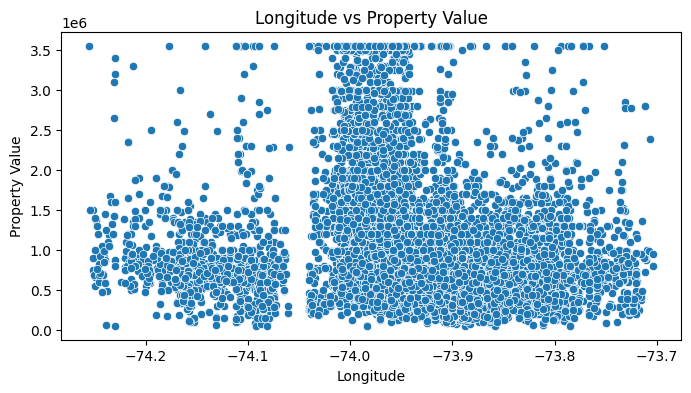

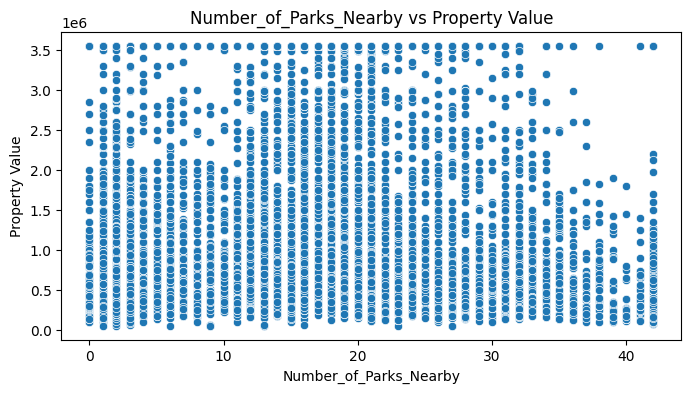

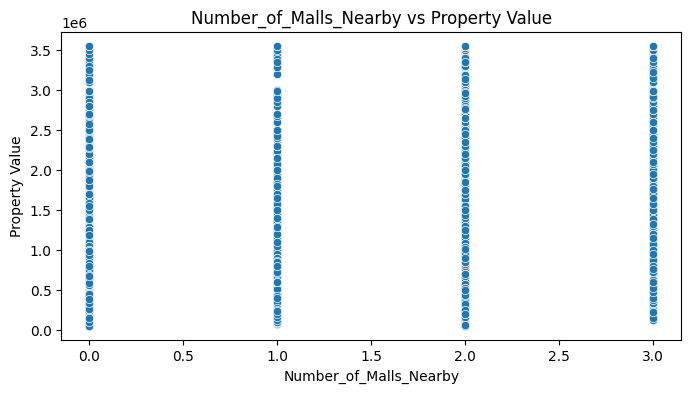

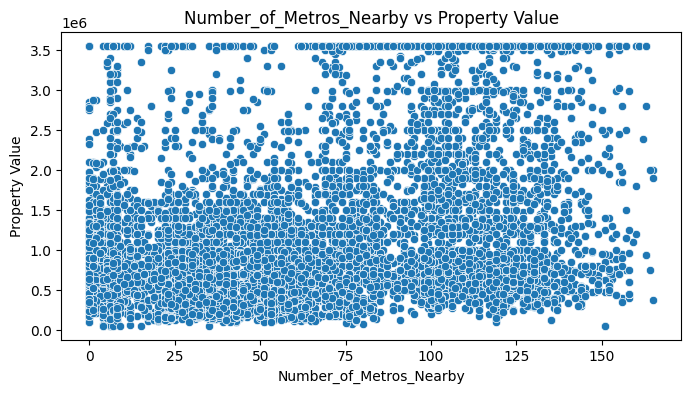

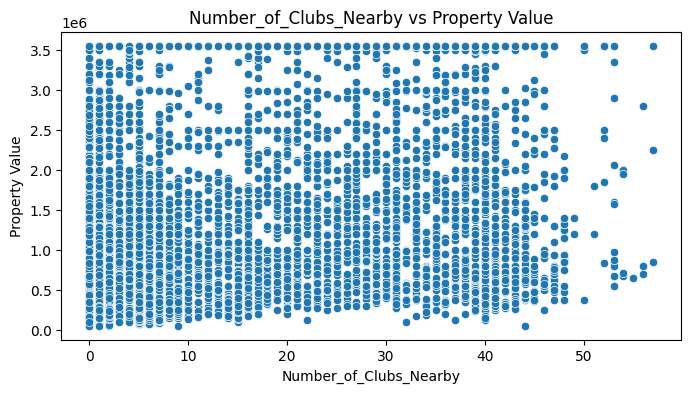

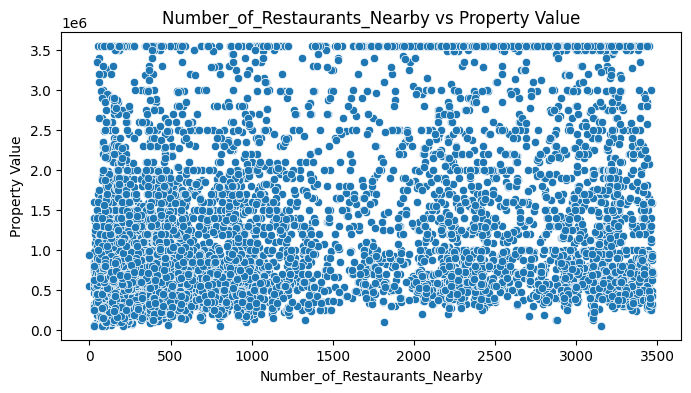

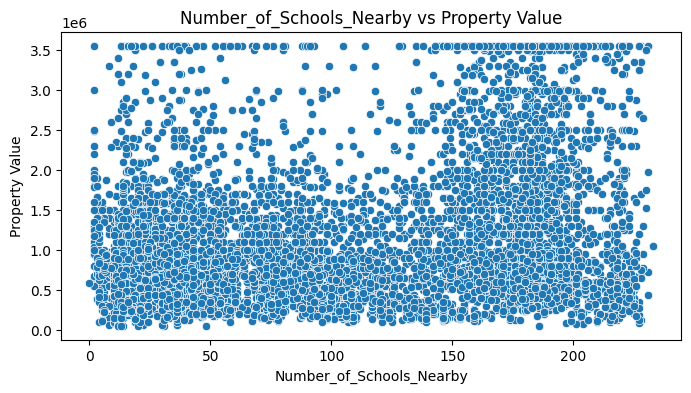

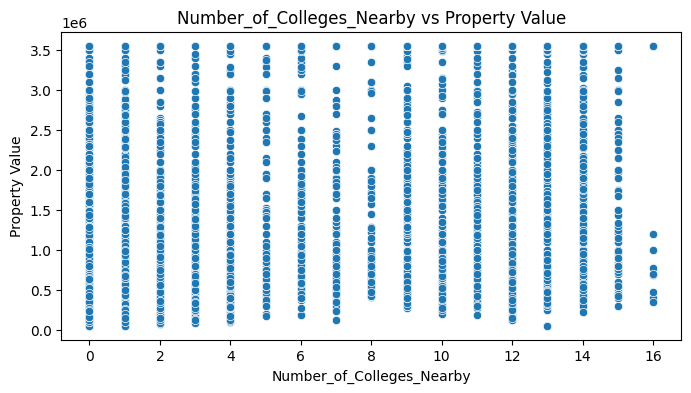

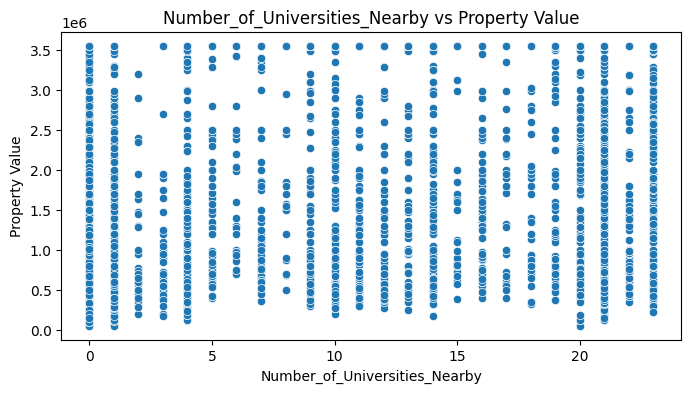

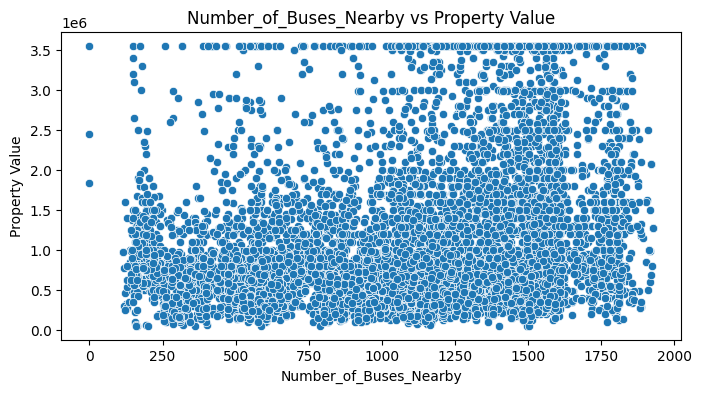

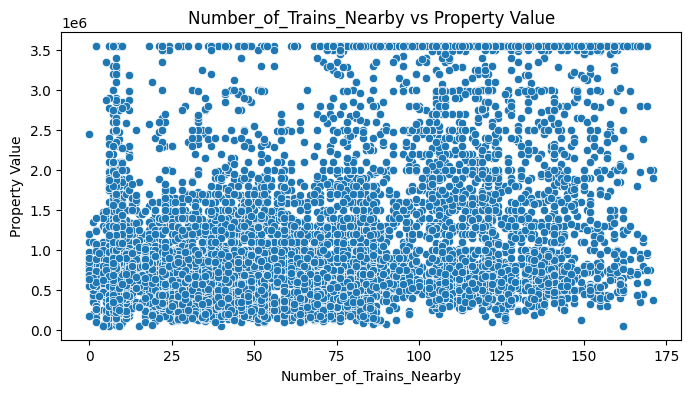

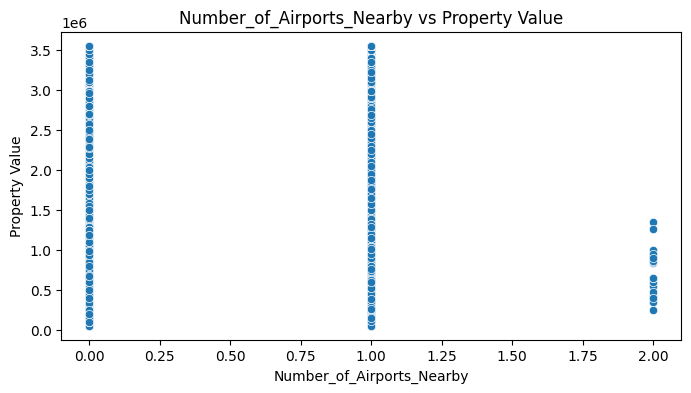

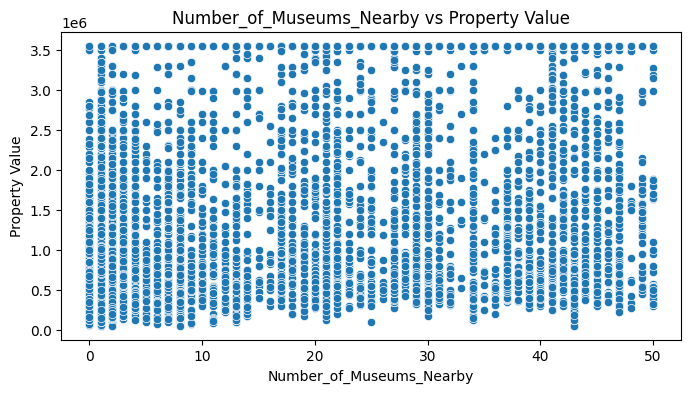

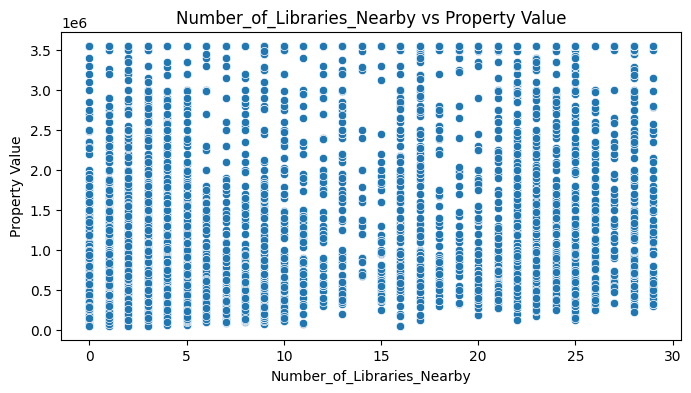

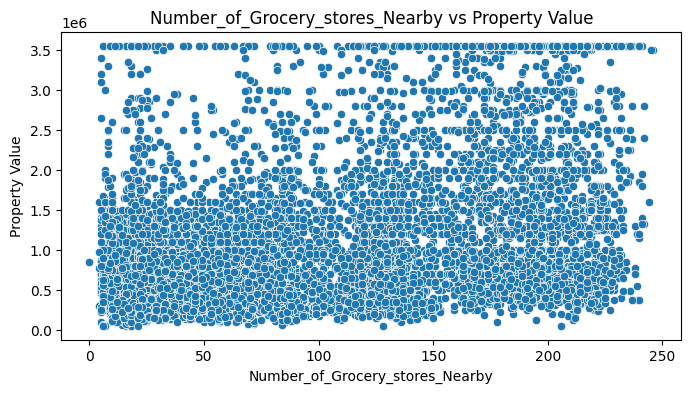

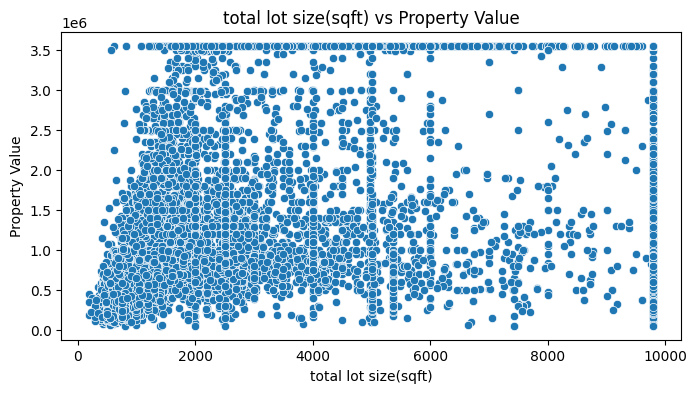

In [32]:

for col in num_cols:
    if col != 'Property Value':
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=df[col], y=df['Property Value'])
        plt.title(f'{col} vs Property Value')
        plt.show()

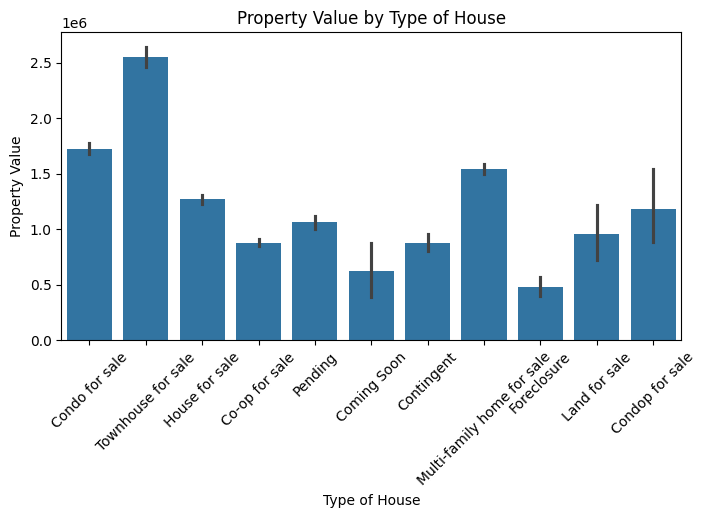

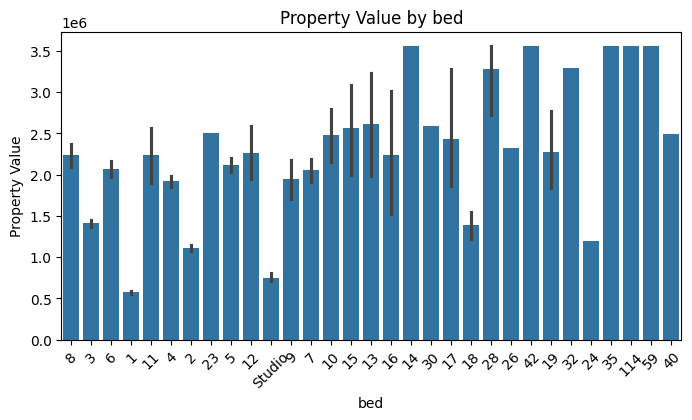

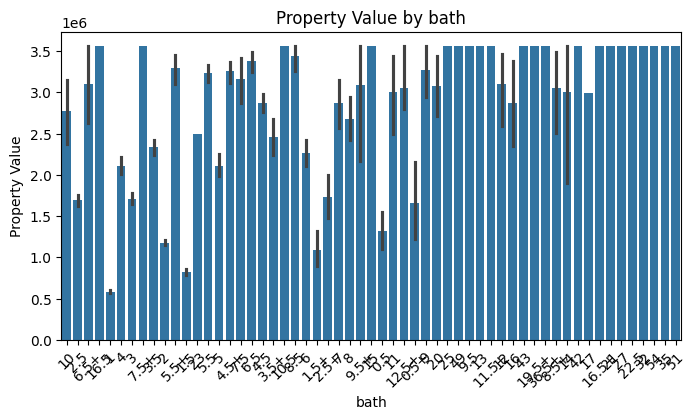

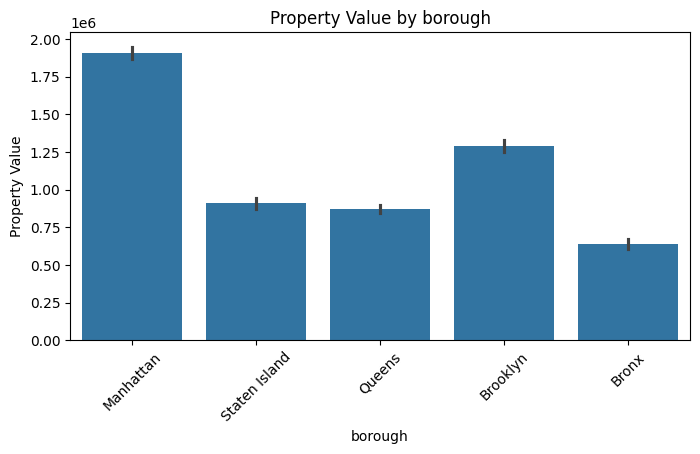

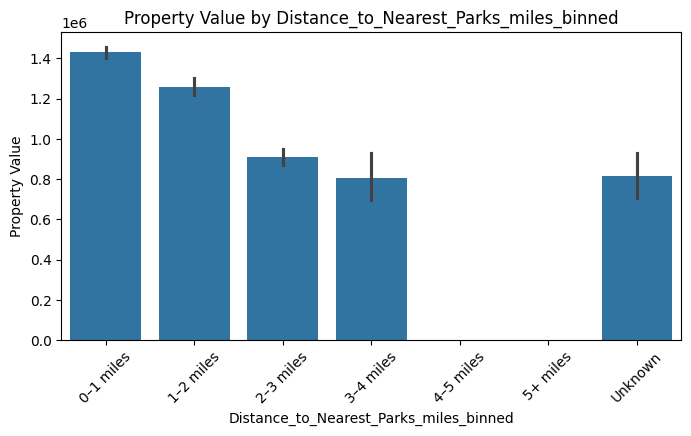

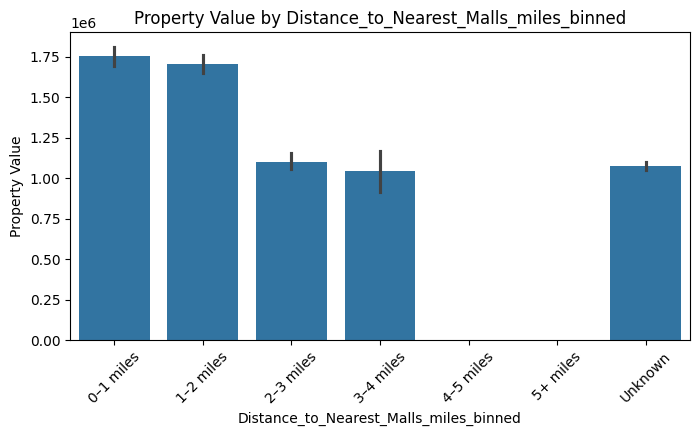

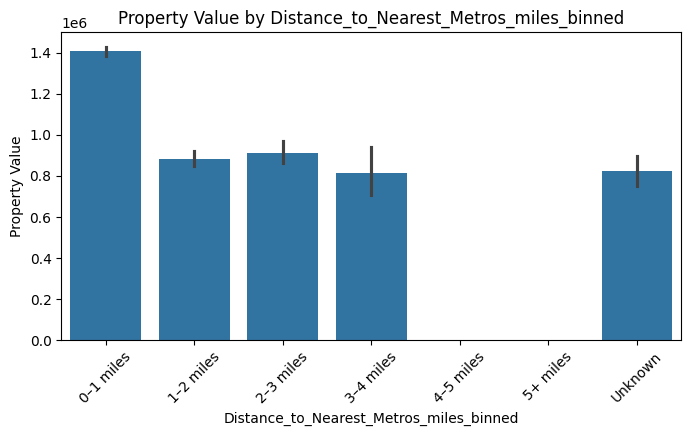

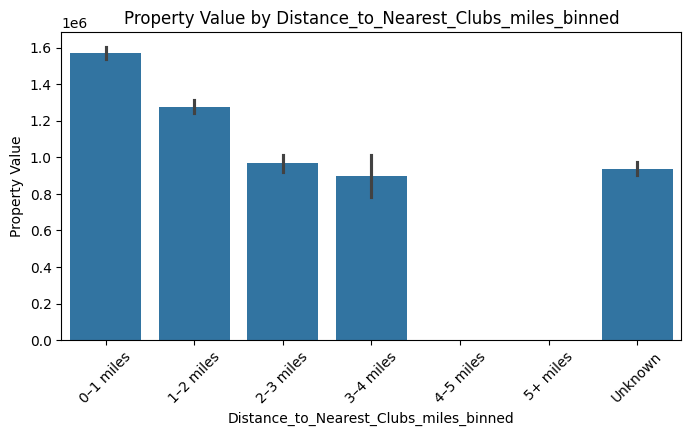

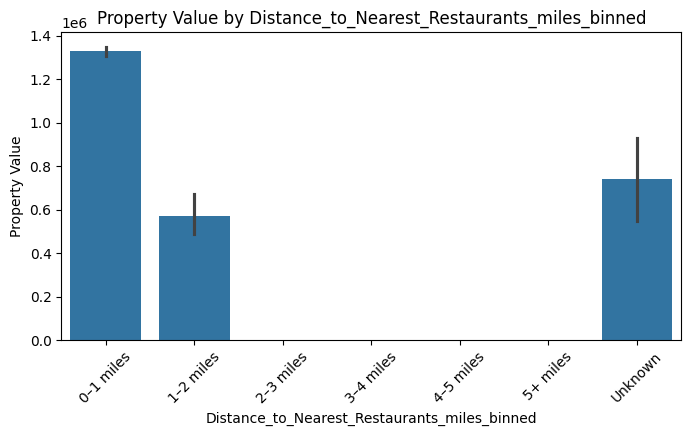

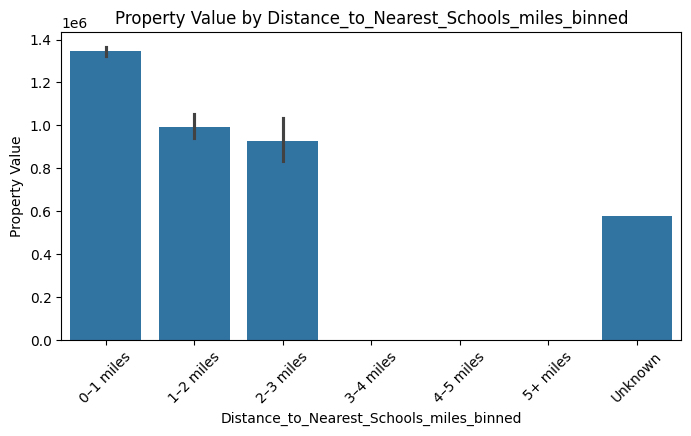

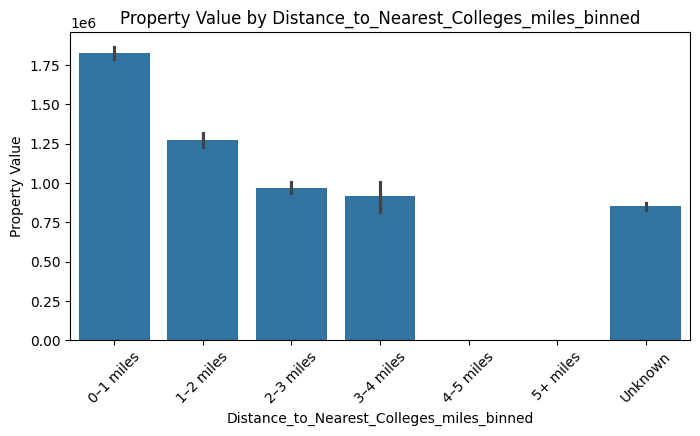

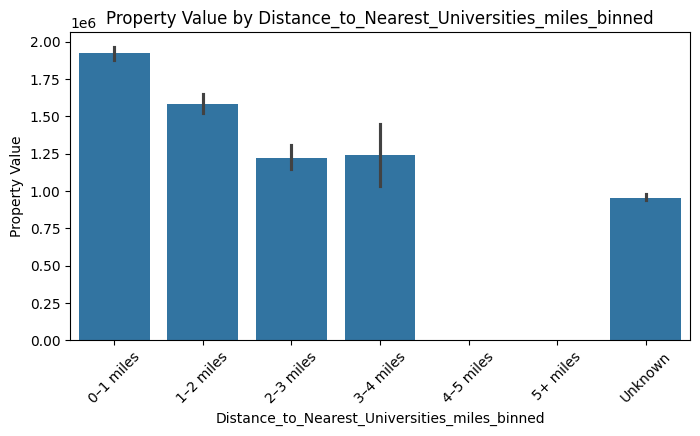

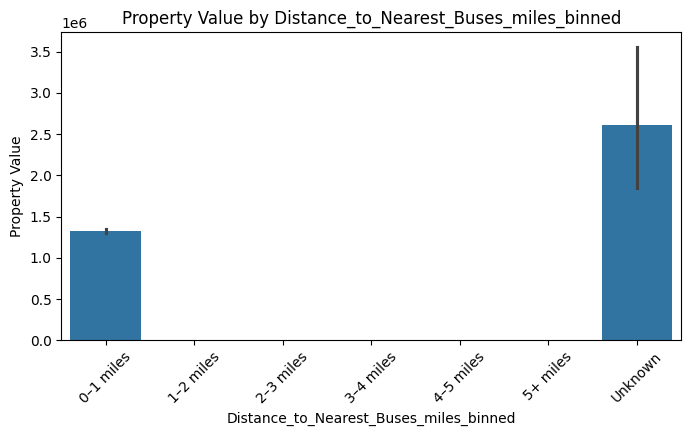

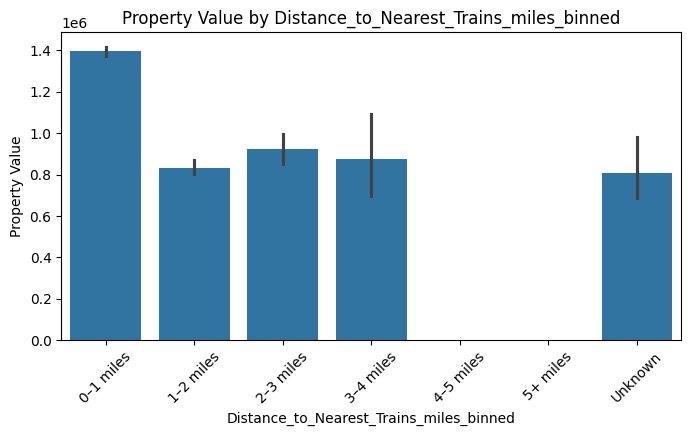

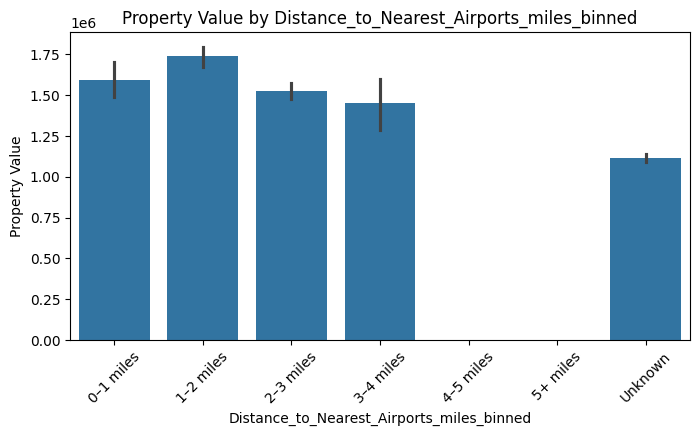

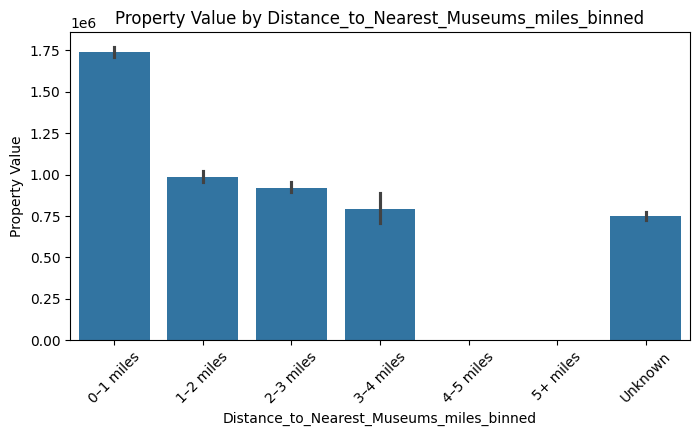

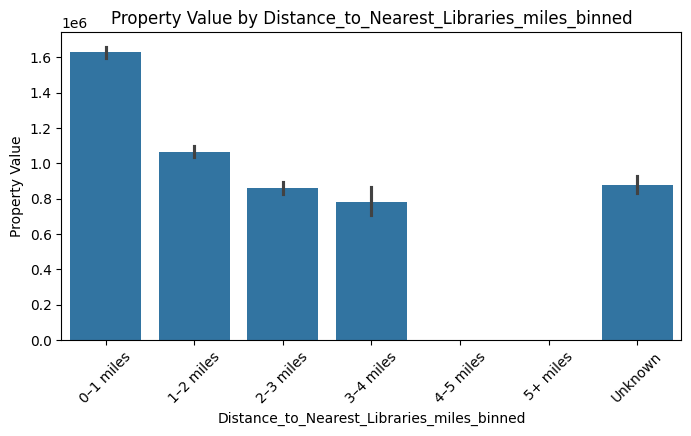

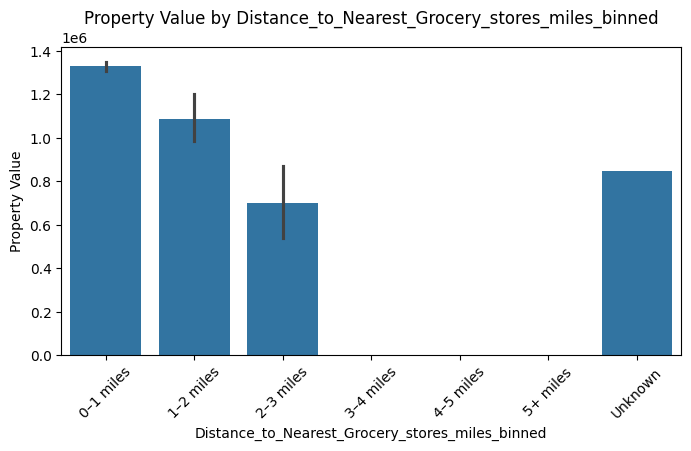

In [33]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=df[col], y=df['Property Value'])
    plt.title(f'Property Value by {col}')
    plt.xticks(rotation=45)
    plt.show()


## Geospatial Analysis of Property Values

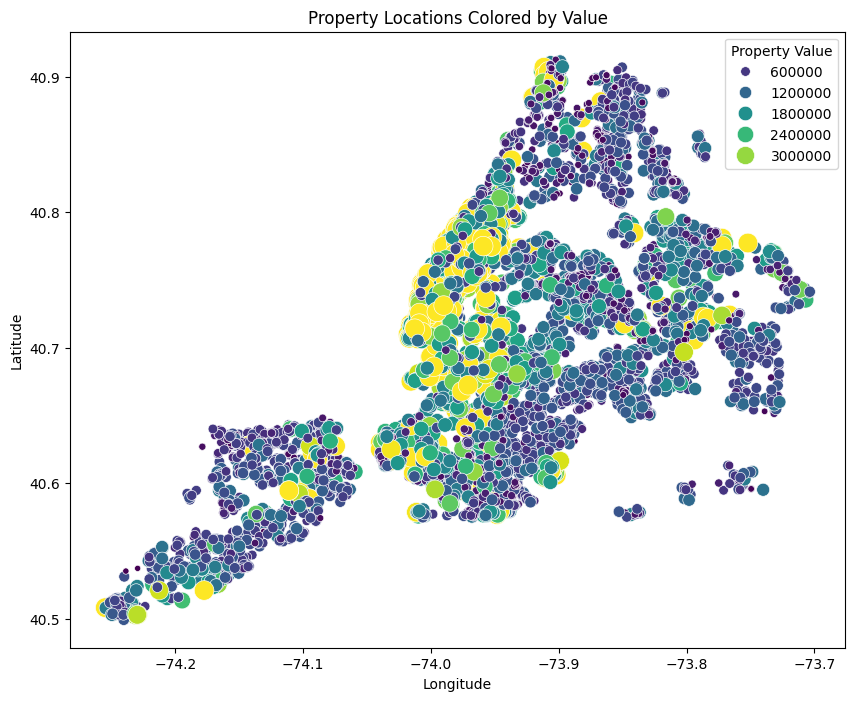

In [34]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Property Value', data=df, 
                palette='viridis', size='Property Value', sizes=(20, 200))
plt.title('Property Locations Colored by Value')
plt.show()

## Log Transformation and Visualization of Target Variable
To reduce the right skewness of the target variable used log transformation.

<Axes: >

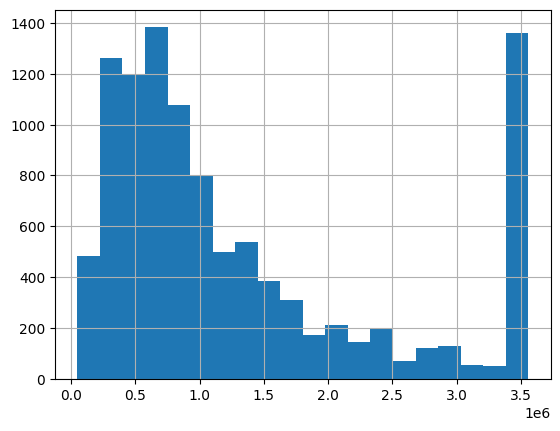

In [35]:
df['Property Value'].hist(bins = 20)

<Axes: >

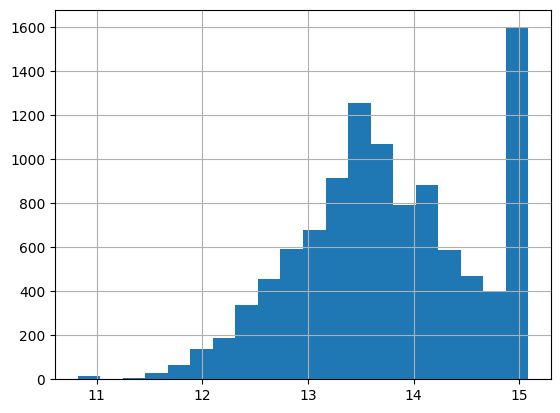

In [36]:
import matplotlib.pyplot as plt
df_encoded['Property Value_log'] = np.log1p(df_encoded['Property Value'])
df_encoded['Property Value_log'].hist(bins = 20)


## Correlation Map
Displaying columns which has more than 0.5 threshold value only

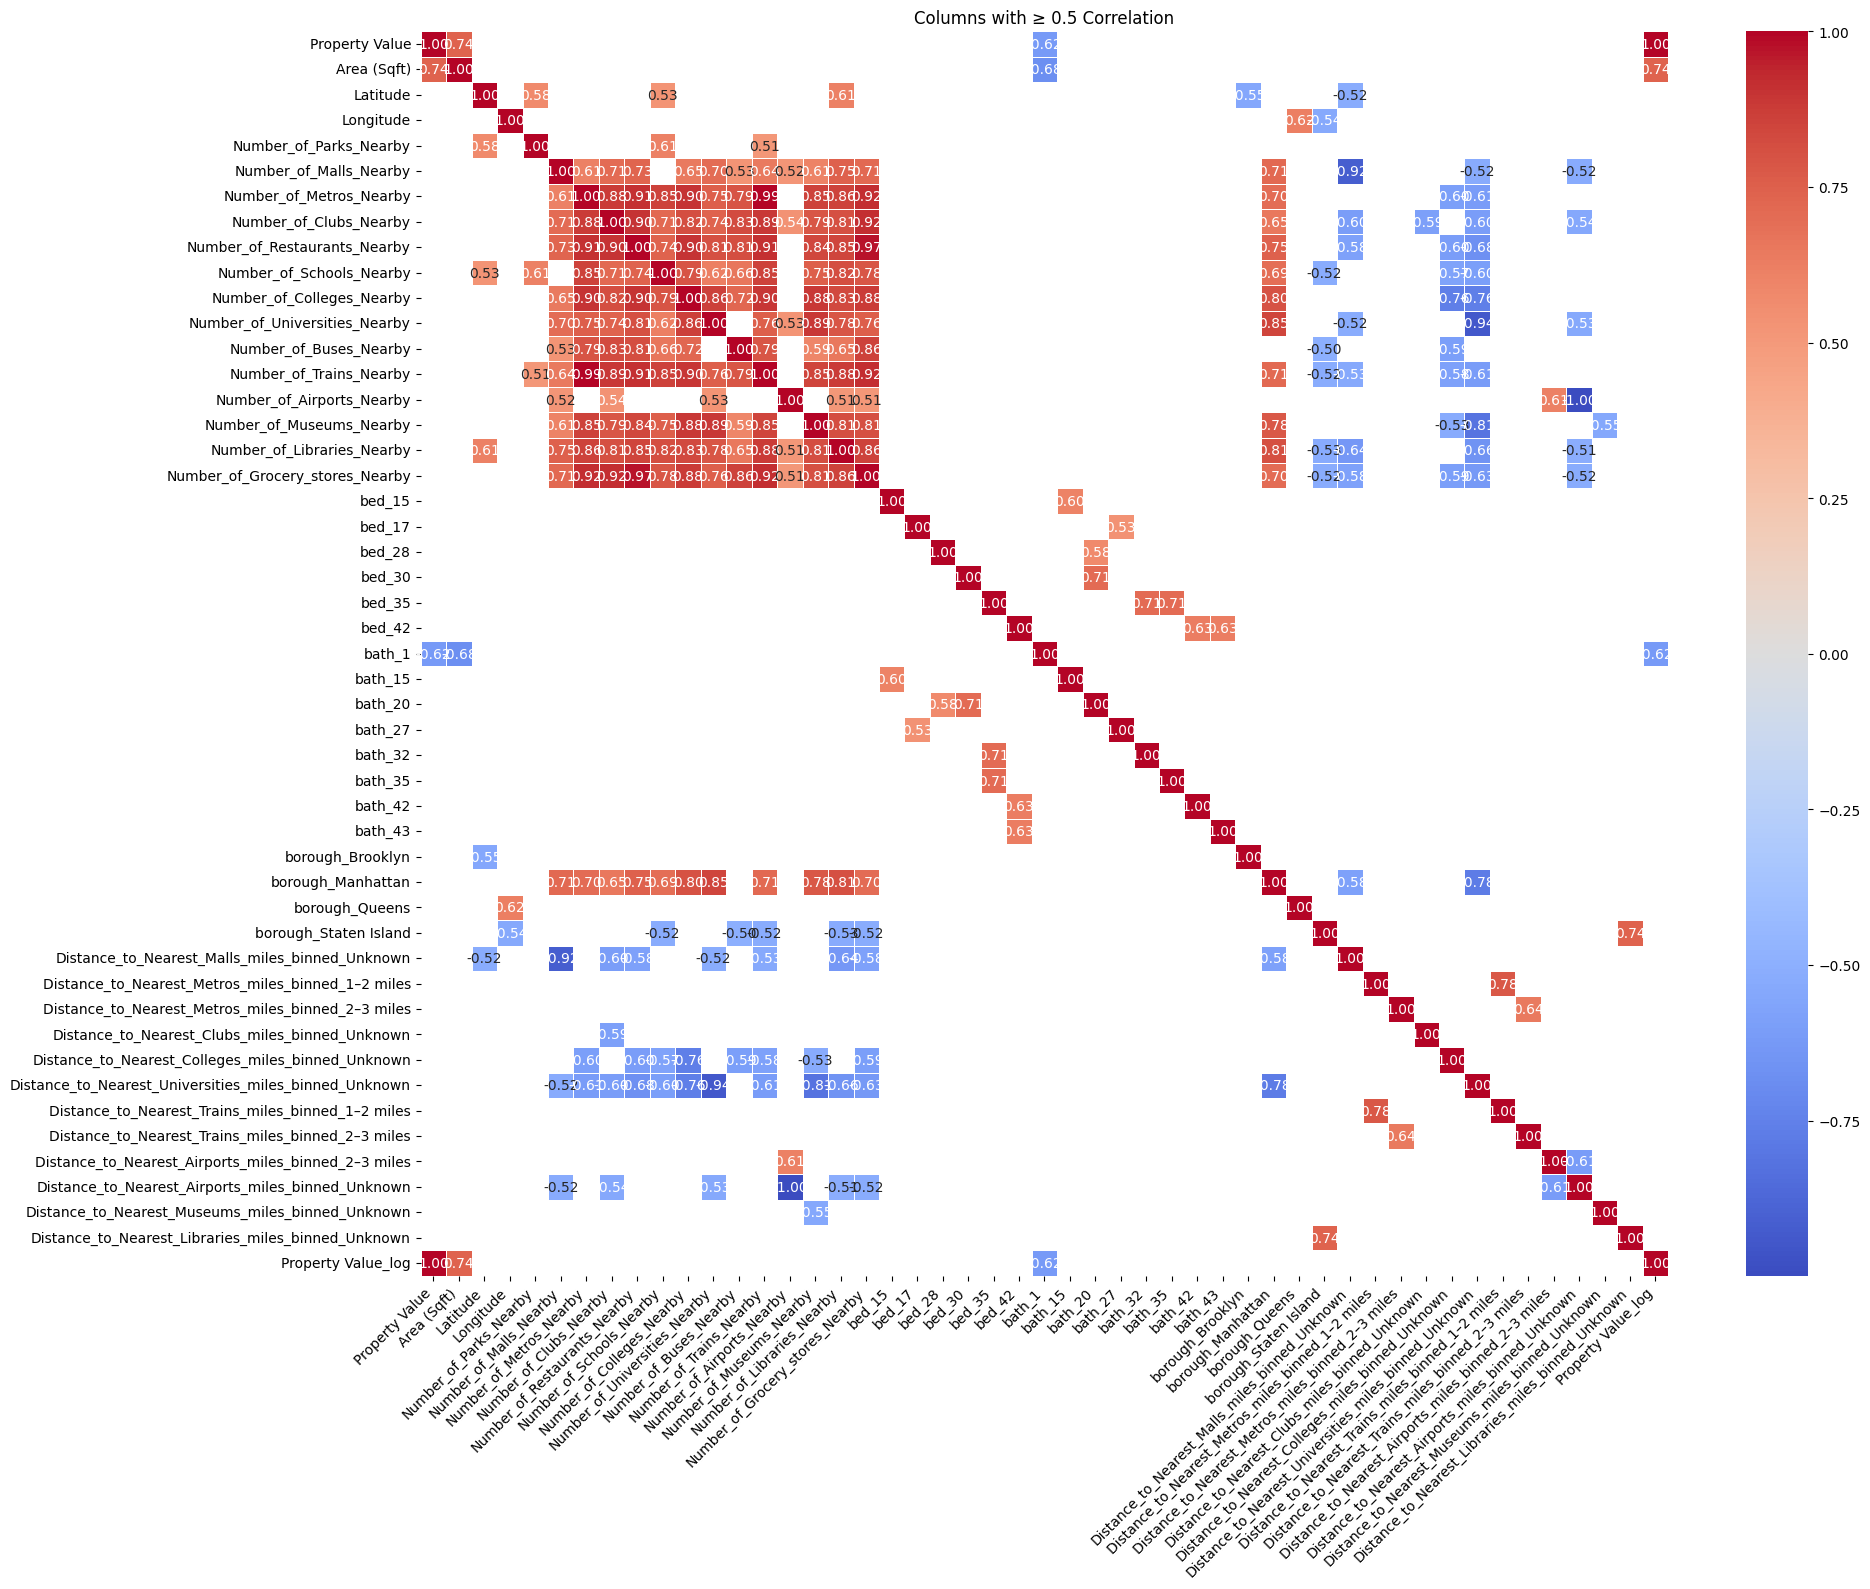

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_encoded.corr(method='spearman')
threshold = 0.5

high_corr_cols = [
    col for col in corr_matrix.columns 
    if ((corr_matrix[col].abs() >= threshold) & (corr_matrix[col] != 1)).any()
]
filtered_corr = corr_matrix.loc[high_corr_cols, high_corr_cols]

plt.figure(figsize=(20, 16))
sns.heatmap(
    filtered_corr,
    annot=True,          
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    mask=(filtered_corr.abs() < threshold)  
)
plt.title(f"Columns with ≥ {threshold} Correlation")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [38]:
df_final = df_encoded.copy()
df_final

Property Value  Area (Sqft)   Latitude  Longitude  \
0           3557950.0      4521.75  40.766474 -73.981266   
1            649000.0      2431.00  40.826130 -73.943006   
2           3557950.0      4521.75  40.787587 -73.969240   
3           3557950.0      4521.75  40.595008 -74.106434   
4            274000.0      1556.00  40.675746 -73.822413   
...               ...          ...        ...        ...   
16607       1290000.0       832.00  40.705254 -74.010340   
16608        150000.0      1000.00  40.880917 -73.834635   
16609       1190000.0      2750.00  40.689108 -73.913931   
16610        499000.0      1029.00  40.722400 -73.856690   
16611        765000.0       545.00  40.740577 -74.008258   

       Number_of_Parks_Nearby  Number_of_Malls_Nearby  \
0                          16                       3   
1                          37                       0   
2                          19                       2   
3                           1                       0   
4                          14                       1   
...                       ...                     ...   
16607                      17                       1   
16608                      25                       0   
16609                      33                       0   
16610                      12                       2   
16611                      20                       3   

       Number_of_Metros_Nearby  Number_of_Clubs_Nearby  \
0                          110                      30   
1                           72                       5   
2                           88                       7   
3                            7                       1   
4                           30                       7   
...                        ...                     ...   
16607                      106                      29   
16608                       24                       1   
16609                       83                      24   
16610                       45                      13   
16611                      117                      35   

       Number_of_Restaurants_Nearby  Number_of_Schools_Nearby  ...  \
0                              2786                       165  ...   
1                               572                       220  ...   
2                              1933                       192  ...   
3                               173                        16  ...   
4                               252                        32  ...   
...                             ...                       ...  ...   
16607                          2371                       165  ...   
16608                            83                        72  ...   
16609                           817                       150  ...   
16610                           827                        57  ...   
16611                          2972                       150  ...   

       Distance_to_Nearest_Libraries_miles_binned_4–5 miles  \
0                                                      0      
1                                                      0      
2                                                      0      
3                                                      0      
4                                                      0      
...                                                  ...      
16607                                                  0      
16608                                                  0      
16609                                                  0      
16610                                                  0      
16611                                                  0      

       Distance_to_Nearest_Libraries_miles_binned_5+ miles  \
0                                                      0     
1                                                      0     
2                                                      0     
3                                                      0  

In [39]:
df_final.drop(columns=["Property Value"], inplace=True)
df_final

Area (Sqft)   Latitude  Longitude  Number_of_Parks_Nearby  \
0          4521.75  40.766474 -73.981266                      16   
1          2431.00  40.826130 -73.943006                      37   
2          4521.75  40.787587 -73.969240                      19   
3          4521.75  40.595008 -74.106434                       1   
4          1556.00  40.675746 -73.822413                      14   
...            ...        ...        ...                     ...   
16607       832.00  40.705254 -74.010340                      17   
16608      1000.00  40.880917 -73.834635                      25   
16609      2750.00  40.689108 -73.913931                      33   
16610      1029.00  40.722400 -73.856690                      12   
16611       545.00  40.740577 -74.008258                      20   

       Number_of_Malls_Nearby  Number_of_Metros_Nearby  \
0                           3                      110   
1                           0                       72   
2                           2                       88   
3                           0                        7   
4                           1                       30   
...                       ...                      ...   
16607                       1                      106   
16608                       0                       24   
16609                       0                       83   
16610                       2                       45   
16611                       3                      117   

       Number_of_Clubs_Nearby  Number_of_Restaurants_Nearby  \
0                          30                          2786   
1                           5                           572   
2                           7                          1933   
3                           1                           173   
4                           7                           252   
...                       ...                           ...   
16607                      29                          2371   
16608                       1                            83   
16609                      24                           817   
16610                      13                           827   
16611                      35                          2972   

       Number_of_Schools_Nearby  Number_of_Colleges_Nearby  ...  \
0                           165                         12  ...   
1                           220                          4  ...   
2                           192                          9  ...   
3                            16                          0  ...   
4                            32                          1  ...   
...                         ...                        ...  ...   
16607                       165                          9  ...   
16608                        72                          1  ...   
16609                       150                          2  ...   
16610                        57                          1  ...   
16611                       150                         14  ...   

       Distance_to_Nearest_Libraries_miles_binned_4–5 miles  \
0                                                      0      
1                                                      0      
2                                                      0      
3                                                      0      
4                                                      0      
...                                                  ...      
16607                                                  0      
16608                                                  0      
16609                                                  0      
16610                                                  0      
16611                                                  0      

       Distance_to_Nearest_Libraries_miles_binned_5+ miles  \
0                                                      0     
1                                                 

## Splitting data set

In [40]:
# Separate target and features
X = df_final.drop(columns=["Property Value_log"])
y = df_final["Property Value_log"]


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Applying standard scalar

In [42]:
from sklearn.preprocessing import StandardScaler

numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


## Trying RandomForestRegresoor

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [44]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f" RMSE: {rmse:,.2f}")
print(f" R² Score: {r2:.4f}")


 RMSE: 0.28
 R² Score: 0.8967
